<a href="https://colab.research.google.com/github/ATrublie/NVDANOR/blob/main/NVDANOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NVDANOR (Night vision/Day and Night prediction / Object recognition at night)

The day/night image dataset consists of 200 RGB color images in two categories: day and night. There are equal numbers of images for each category.

I build a classifier that can accurately label these images as day or night, and also implemented ResNet for object detection in that pictures as well as VGG for training on this  model and being able to clasiffy them. This model relies on finding distinguishing features between the two types of images!

*Note: All images come from the [AMOS dataset](http://cs.uky.edu/~jacobs/datasets/amos/) (Archive of Many Outdoor Scenes).*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=9311f883218e9b93da54e77659e280e7e05b2e21559662ac865626dec069716e
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet


In [ ]:
!pip install Keras-Applications


     |████████████████████████████████| 50 kB 3.4 MB/s 


In [ ]:
from keras_applications.resnet import ResNet50

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50, decode_predictions

ModuleNotFoundError: ignored

Required Libraries implementation (including for ResNet)

In [ ]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np


##### lib for ResNet
from keras.preprocessing.image import image
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

In [ ]:
# Image data directories
image_dir_training = "/content/drive/MyDrive/images/train"
image_dir_test = "/content/drive/MyDrive/images/test"

## First of all i am going to load the dataset and visualize it

These first few lines of code will load the train folder and its subfolders day/night images and store all of them in a variable, `IMAGE_LIST`. This list contains the images and their associated label ("day" or "night"). 

In [ ]:
def load_dataset(image_dir):
    '''This function loads in images and their labels and places them in a list
    im_list[0][:] will be the first image-label pair in the list'''
    
    im_list = []
    image_types = ["day", "night"]
    
    # Iterate through each color folder
    for im_type in image_types:
        
        # Iterate through each image file in each image_type folder
        # glob reads in any image with the extension "image_dir/im_type/*"
        for file in glob.glob(os.path.join(image_dir, im_type, "*")):
            
            # Read in the image
            im = mpimg.imread(file)
            
            # Check if the image exists/if it's been correctly read-in
            if not im is None:
                # Append the image, and it's type (red, green, yellow) to the image list
                im_list.append((im, im_type))
    
    return im_list

In [ ]:
# Load training data
IMAGE_LIST = load_dataset(image_dir_training)

## Step 2: Preprocess the data input images.

This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and numerical labels.
1. Resizing every image to a standard size
2. Encode the target variables

In [ ]:
def standardize_input(image):
    
    # Resize image and pre-process so that all "standard" images are the same size
    standard_im = cv2.resize(image, (1100, 600))
    
    return standard_im

In [ ]:
def encode(label):
    # encode day as 1, night as 0
    numerical_val = 0
    if(label == 'day'):
        numerical_val = 1
    
    return numerical_val

In [ ]:
def preprocess(image_list):
    
    #standardize and encode the input data
    standard_list = []
    
    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]
        
        # Standardize the image
        standardized_im = standardize_input(image)
        
        # Create a numerical label
        binary_label = encode(label)
        
        # Append the image, and it's one hot encoded label to the full, processed list of image data
        standard_list.append((standardized_im, binary_label))
    
    return standard_list

In [ ]:
# Standardize all training images
STANDARDIZED_LIST = preprocess(IMAGE_LIST)

Shape: (600, 1100, 3)
Label [1 = day, 0 = night]: 1


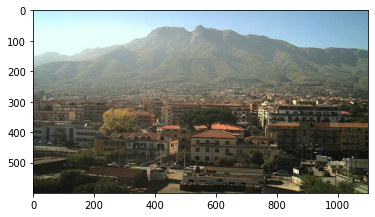

In [ ]:
# Display a standardized image and its label

# Select an image by index
image_num = 50
selected_image = STANDARDIZED_LIST[image_num][0]
selected_label = STANDARDIZED_LIST[image_num][1]

# Display image and data about it
plt.imshow(selected_image)
print("Shape: "+str(selected_image.shape))
print("Label [1 = day, 0 = night]: " + str(selected_label))

# **Step 3: Feature Extraction**

I need to create a feature that represents the brightness in an image. For that i will be extracting the average brightness using HSV colorspace. Specifically, we'll use the V channel (a measure of brightness), add up the pixel values in the V channel, then divide that sum by the area of the image to get the average Value of the image.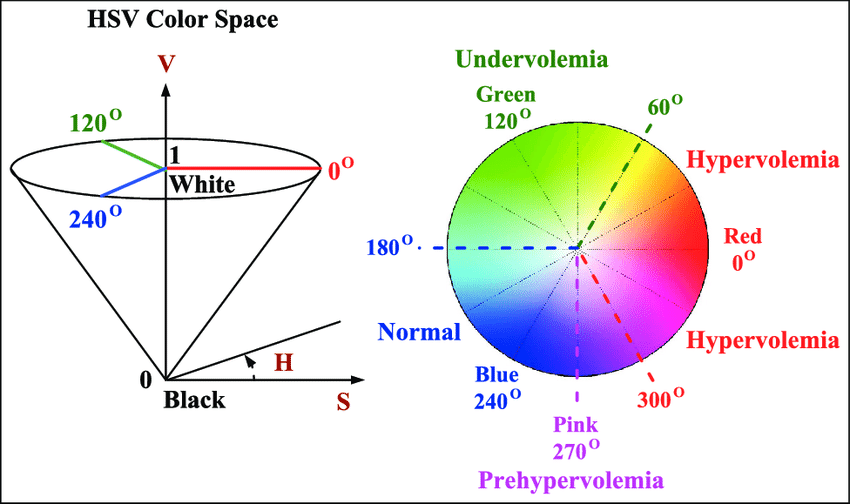

In [ ]:
# Find the average Value or brightness of an image
def avg_brightness(rgb_image):
    # Convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    # Add up all the pixel values in the V channel
    sum_brightness = np.sum(hsv[:,:,2])
    area = 600*1100.0  # pixels
    
    # find the avg
    avg = sum_brightness/area
    
    return avg

Avg brightness: 123.64255151515151


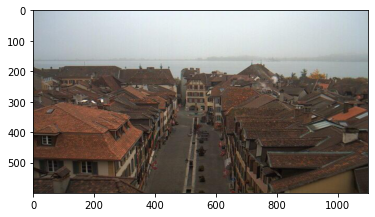

In [ ]:
# Testing average brightness levels
# Looking at a number of different day and night we need to find what average brightness value separates the two types of images

# As an example, a "night" image is loaded in and its avg brightness is displayed
image_num = 23
test_im = STANDARDIZED_LIST[image_num][0]

avg = avg_brightness(test_im)
print('Avg brightness: ' + str(avg))
plt.imshow(test_im)

## Step 4: Building the classifier

Now we can us that average brightness feature and turn it into a classifier that takes in a standardized image and returns a `predicted_label` for that image. This `estimate_label` function should return a value: 0 or 1 (night or day, respectively).

In [ ]:
# This function should take in RGB image input
def estimate_label(rgb_image, threshold):
    
    # Extract average brightness feature from an RGB image 
    avg = avg_brightness(rgb_image)
        
    # Use the avg brightness feature to predict a label (0, 1)
    predicted_label = 0
    #threshold = 120
    if(avg > threshold):
        # if the average brightness is above the threshold value, we classify it as "day"
        predicted_label = 1
    # else, the predicted_label can stay 0 (it is predicted to be "night")
    
    return predicted_label    
    

## Step 5: We need to Evaluate our Classifier and Optimize it if possible

Here is where we test our classification algorithm using our test set of data that we set aside at the beginning.
Below, we load in the test dataset, standardize it using the `standardize` function we defined above, and then **shuffle** it. (Shuffling ensures that order will not play a role in testing accuracy).


In [ ]:
# Load test data
TEST_IMAGE_LIST = load_dataset(image_dir_test)

# Standardize the test data
STANDARDIZED_TEST_LIST = preprocess(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

In [ ]:
# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images(test_images, threshold):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]

        # Get predicted label from your classifier
        predicted_label = estimate_label(im, threshold)

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels

In [ ]:
# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST, threshold=99)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

Accuracy: 0.9375
Number of misclassified images = 10 out of 160


# **Makeing a prediction using the ResNet-50 model in Keras**








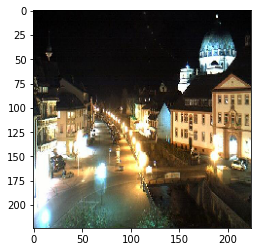

In [ ]:
img = image.load_img('/content/drive/MyDrive/images/test/night/20151109_180151.jpg', target_size = (224, 224))
plt.imshow(img)

In [ ]:
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

ValueError: ignored

In [ ]:
model = ResNet50(weights='imagenet')

AttributeError: ignored

In [ ]:
preds = model.predict(img)
print('Predicted:', decode_predictions(preds, top=3)[0])

NameError: ignored

# **Testing our model with VGG**

In [ ]:
#Lib we need for VGG
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# We need to set path for our folders
base_dir = '/content/drive/MyDrive/images'
train_dir = '/content/drive/MyDrive/images/train'
train_day_dir = '/content/drive/MyDrive/images/train/day'
train_night_dir = '/content/drive/MyDrive/images/train/night'
test_dir = '/content/drive/MyDrive/images/test'
test_day_dir = '/content/drive/MyDrive/images/test/day'
test_night_dir = '/content/drive/MyDrive/images/test/night'

In [ ]:
num_day_train = len(os.listdir(train_day_dir))
num_night_train = len(os.listdir(train_night_dir))

num_day_test = len(os.listdir(test_day_dir))
num_night_test= len(os.listdir(test_night_dir))

In [ ]:
print("Total Train Day Images",num_day_train)
print("Total Train Night",num_night_train)
print("--")
print("Total Test Day Images", num_day_test)
print("Total Test Day Images",num_night_test)
total_train = num_day_train+num_night_train
total_test = num_day_test+num_night_test
print("Total Train Images",total_train)
print("--")
print("Total Testing Images",total_test)

Total Train Day Images 120
Total Train Night 120
--
Total Test Day Images 80
Total Test Day Images 80
Total Train Images 240
--
Total Testing Images 160


In [ ]:
# Resizeing images to (224,224) because VGG-16 only accepts that image size.
IMG_SHAPE  = 224
batch_size = 32

In [ ]:
#Preprocing required that will include: Rescaling and shuffling
image_gen_train = ImageDataGenerator(rescale = 1./255)
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
directory = train_dir,
shuffle= True,
target_size = (IMG_SHAPE,IMG_SHAPE),
class_mode = 'binary')

image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
directory=test_dir,
target_size=(IMG_SHAPE, IMG_SHAPE),
class_mode='binary')

Found 240 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [ ]:
#Now need to download pre-trained weights of our VGG
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#Stop
for layer in pre_trained_model.layers:
 print(layer.name)
layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
#MDF (Max polling, one dense layer, one dropout, and one output with the last layer of VGG-16).
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

In [ ]:
#Merge
model = tf.keras.Model(pre_trained_model.input, x)

In [ ]:
#Compiling
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

In [ ]:
#Now i can start training process.
vgg_classifier = model.fit(train_data_gen,
steps_per_epoch=(total_train//batch_size),
epochs = 5, verbose = 1)

Epoch 1/5
7/7 [==============================] - 414s 59s/step - loss: 2.7193 - acc: 0.4866
Epoch 2/5
7/7 [==============================] - 377s 58s/step - loss: 0.7260 - acc: 0.5144
Epoch 3/5
7/7 [==============================] - 380s 53s/step - loss: 0.7485 - acc: 0.4712
Epoch 4/5
7/7 [==============================] - 375s 53s/step - loss: 0.5193 - acc: 0.7452
Epoch 5/5
7/7 [==============================] - 373s 53s/step - loss: 0.0953 - acc: 0.9808


In [ ]:
#Testing my model with testing data
result = model.evaluate(test_data_gen,batch_size=batch_size)
print("test_loss, test accuracy",result)

5/5 [==============================] - 81s 16s/step - loss: 0.0722 - acc: 0.9688
test_loss, test accuracy [0.07216286659240723, 0.96875]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
acc = ['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

NameError: ignored


## Conclusion

With my model i achieved an accuracy of **93.75%** by using only one feature extraction, i.e the average brightness of the image. I could work more on this, for example features that involve Hue (a gradation or variety of a color spectrum) and Saturation channels could be extracted for more features which may resault in more accuracy. I also could make more epochs training instead of 5 to achieve more accuracy. Last but not least i can also implement more deep learning models to see different results.
